<h1>Analysis of the SOM maps Order Time, Cuisin Preference and Order Volumes</h1>

In [1]:
from os.path import join
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn.cluster import KMeans, AgglomerativeClustering
#from sklearn.neighbors import KNeighborsClassifier

from minisom import MiniSom

In [2]:
## Import Matplotlib functions to create MiniSOM visualizations

from matplotlib.patches import RegularPolygon, Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib import colors as mpl_colors
from matplotlib.colors import LinearSegmentedColormap

from matplotlib.lines import Line2D
import seaborn as sns

from matplotlib import __version__ as mplver

In [3]:
df = pd.read_csv(join('..', 'data', 'treated_ABCDEats_data.csv'))
df.columns

Index(['customer_id', 'customer_region', 'customer_age', 'vendor_count',
       'product_count', 'is_chain', 'first_order', 'last_order', 'last_promo',
       'payment_method', 'CUI_American', 'CUI_Asian', 'CUI_Beverages',
       'CUI_Cafe', 'CUI_Chicken Dishes', 'CUI_Chinese', 'CUI_Desserts',
       'CUI_Healthy', 'CUI_Indian', 'CUI_Italian', 'CUI_Japanese',
       'CUI_Noodle Dishes', 'CUI_OTHER', 'CUI_Street Food / Snacks',
       'CUI_Thai', 'DOW_0', 'DOW_1', 'DOW_2', 'DOW_3', 'DOW_4', 'DOW_5',
       'DOW_6', 'HR_0', 'HR_1', 'HR_2', 'HR_3', 'HR_4', 'HR_5', 'HR_6', 'HR_7',
       'HR_8', 'HR_9', 'HR_10', 'HR_11', 'HR_12', 'HR_13', 'HR_14', 'HR_15',
       'HR_16', 'HR_17', 'HR_18', 'HR_19', 'HR_20', 'HR_21', 'HR_22', 'HR_23',
       'total_spending', 'total_orders', 'cuisine_diversity',
       'primary_cuisine', 'weekend_orders', 'underweekend_orders',
       'weekend_ratio', 'lunch_orders', 'dinner_orders', 'meal_preference',
       'morning_orders', 'midday_orders', 'evening_orde

In [4]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label)

    

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)




    return sf 

In [5]:
# Get the weights from the trained SOM
weights = sm.get_weights()

NameError: name 'sm' is not defined

<h1>Order Time Features</h1>

In [25]:
order_time_features = [
    'morning_orders', 'midday_orders', 'evening_orders', 'night_orders', 'drinking_orders'
]
order_time_features

['morning_orders',
 'midday_orders',
 'evening_orders',
 'night_orders',
 'drinking_orders']

In [26]:
# M = 0
# N = 0
# neighborhood_function = None 
# topology = None 
# n_feats = len(metric_features)
# learning_rate = None

M = 15
N = 15
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(order_time_features)
learning_rate = .7


som_data = df[order_time_features].values

sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 


print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))



# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))


Before training:
QE 0.6927
TE 0.9718
After training:
QE 0.4518
TE 0.212


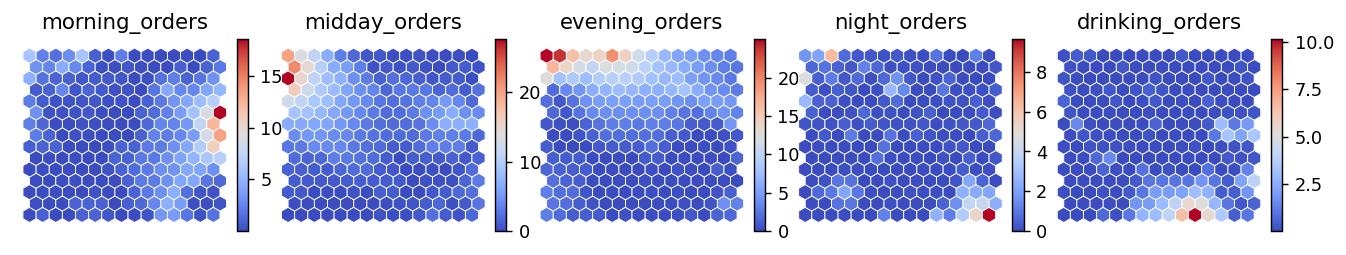

In [ ]:
##############################
# Plot Component Planes
##############################



figsize=(10, 10)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(1,5,wspace=.05, hspace=.05)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(order_time_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=order_time_features[cpi],
                    cmap=cm.coolwarm,
                    )

These Self-Organizing Maps (SOMs) show ordering patterns across different times of day in what appears to be a restaurant or food service setting.

Key patterns:
- Morning: Scattered hotspots, suggesting variable breakfast order patterns
- Midday: More concentrated hotspots, indicating consistent lunch rush patterns
- Evening: Distinct clusters, showing regular dinner service patterns
- Night: Mostly uniform with one strong outlier, suggesting late-night ordering follows predictable patterns
- Drinking: Very uniform with minimal variation, indicating consistent beverage ordering behavior

The color scales vary (0-15, 0-20, 0-8, etc.), showing different intensity ranges for each time period. The hexagonal grid pattern helps visualize clustering of similar orders.

The darker red spots represent order peaks or anomalies in the typical patterns, while the blue regions show baseline ordering behavior.

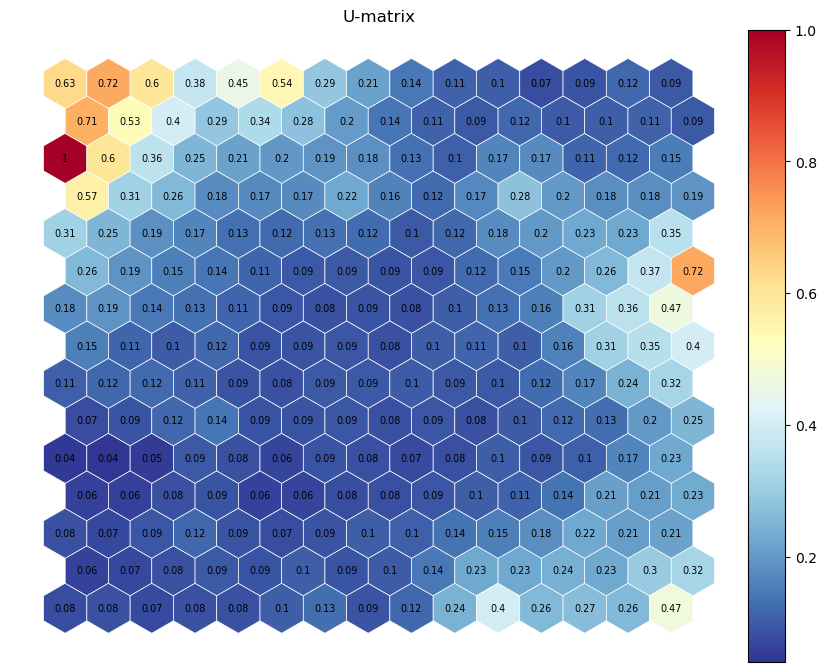

In [28]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

This U-matrix visualization shows the unified distance matrix of the SOM, revealing the clustering structure and relationships between nodes:

Key observations:
- Dark red cluster in top-left (value 1.0) indicates a strong isolated cluster
- Yellow-orange regions (0.6-0.8) show transition zones between clusters
- Predominant blue areas (0.1-0.3) suggest many closely related nodes
- Bottom-right has a gradient from blue to lighter values, indicating a gradual transition between node characteristics

The hexagonal topology preserves neighborhood relationships while the color intensity represents distances between adjacent nodes, with darker blue showing similarity and red showing dissimilarity.

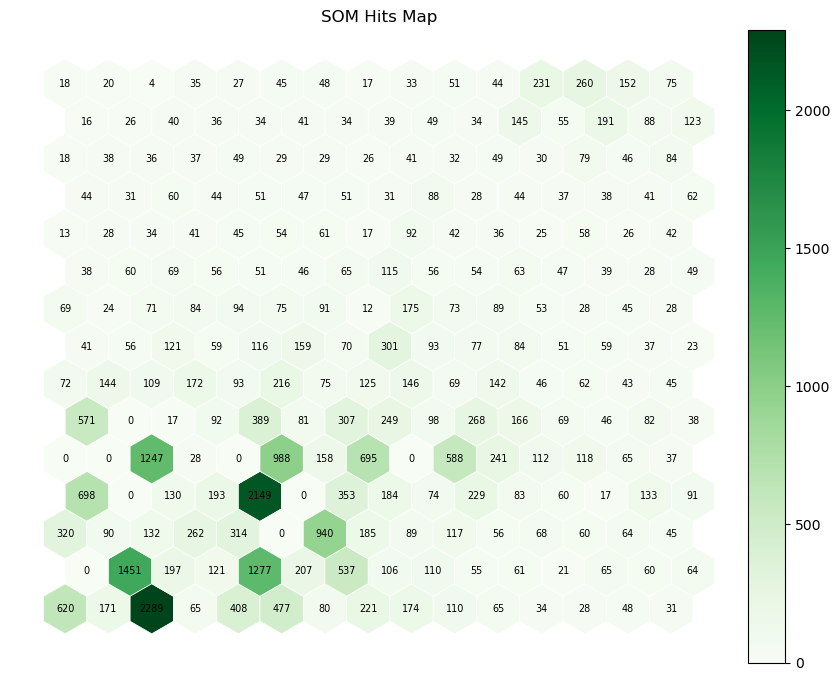

In [29]:
hitsmatrix = sm.activation_response(df[order_time_features].values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )


This hits map reveals the frequency of node activations in the SOM:

Key concentrations:
- Three dark green hotspots showing highest activation (2000+ hits):
  - Bottom-left quadrant: 2783 hits
  - Center area: 2142 hits
  - Left-center: 1451 hits
- Medium activation zones (500-1000 hits) scattered in bottom-center region
- Low activation areas (0-100 hits) predominantly in top half

The pattern suggests concentrated clustering of similar data points in specific regions, particularly in the bottom-left portion of the map, while the upper regions show more dispersed activation patterns.

## Clustering with SOMs: K-means SOM vs Emergent SOM
- In **k-means SOM**, the *number of units should be equal to the expected number of clusters*, and thus each cluster should be represented by a single unit. 
- In **emergent SOM**, a very *large number of units is used*. These very large SOM allow for very clear U-Matrices and are useful for detecting quite clearly the underlying structure of the data. This technique can be **used together with other clustering algorithms**.

<h1>Cuisine Preference Clustering</h1>

In [6]:
cui_features = ['CUI_Japanese', 'CUI_Chinese', 'CUI_Indian', 'CUI_Thai', 'CUI_Desserts', 'CUI_Cafe', 'CUI_Street Food / Snacks', 'CUI_Beverages','CUI_Asian','CUI_OTHER']

In [9]:
# M = 0
# N = 0
# neighborhood_function = None 
# topology = None 
# n_feats = len(metric_features)
# learning_rate = None

M = 20
N = 20
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(cui_features)
learning_rate = .7




# Increase map size
M = 20
N = 20

# Adjust learning parameters
learning_rate = 0.5
neighborhood_function = 'gaussian'
n_iterations = 30000

# Train with more epochs for better feature representation
sm = MiniSom(M, N, 
             n_feats,
             learning_rate=learning_rate, 
             topology='hexagonal',
             neighborhood_function=neighborhood_function)

# For visualization, use 2x5 grid to show all features
#subfigs = fig.subfigures(2, 5, wspace=.08, hspace=.07)


som_data = df[cui_features].values

# sm = MiniSom(M, N,              # 10x10 map size
#              n_feats,           # Number of the elements of the vectors in input.
#              learning_rate=learning_rate, 
#              topology=topology, 
#              neighborhood_function=neighborhood_function, 
#              activation_distance='euclidean',
#              random_seed=42
#              )

# # Initializes the weights of the SOM picking random samples from data.
# sm.random_weights_init(som_data) 


print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))



# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))


Before training:
QE 19.0924
TE 0.9968
After training:
QE 3.3393
TE 0.2152


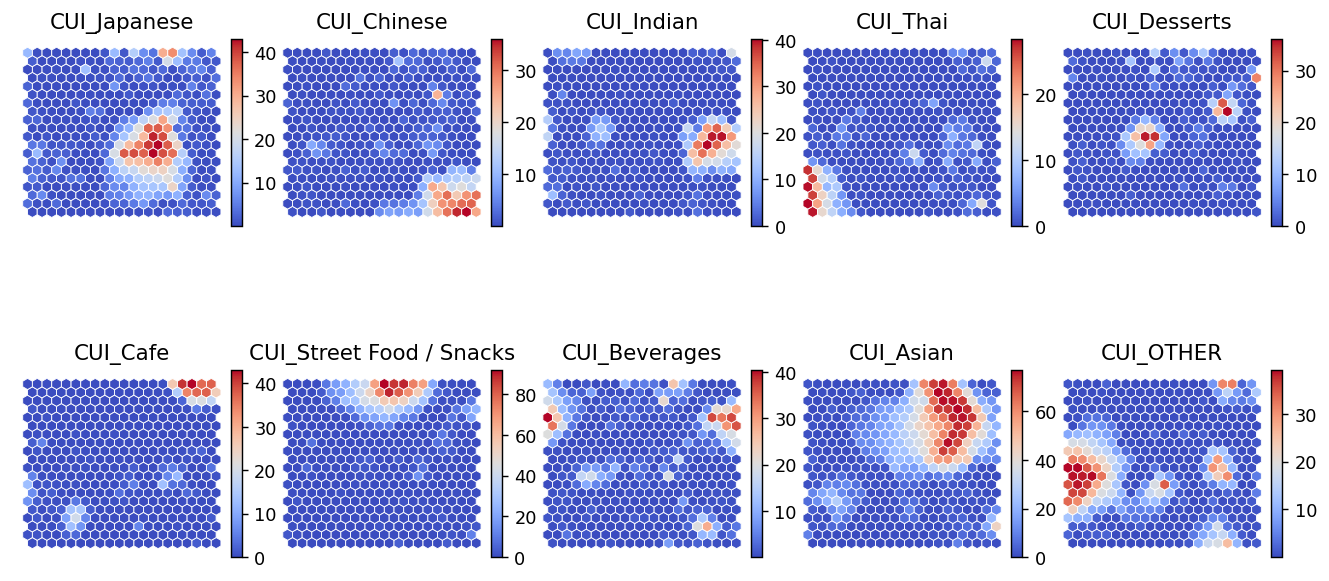

In [15]:
##############################
# Plot Component Planes
##############################

figsize=(10, 5)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

#subfigs = fig.subfigures(2, 5, wspace=.08, hspace=.07)  # 2x5 for 10 features
subfigs = fig.subfigures(2, 5, wspace=.08, hspace=.07).flatten()  # 2x5 for 10 features
colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi in range(len(cui_features)):
    if cpi >= len(subfigs) or cpi >= weights.shape[2]:
        break
    sf = subfigs[cpi]
    # Rest of plotting code
    
    matrix_vals = weights[:, :, cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=cui_features[cpi],
                    cmap=cm.coolwarm,
                    )

Analysis of cuisine distribution SOMs across 20x20 hexagonal grid:

Japanese: Strong cluster center-right (40+ intensity)
Chinese: Concentrated bottom-right hotspot (30+)
Indian: Right-side cluster (30+)
Thai: Left-edge linear pattern (20+)
Desserts: Two distinct clusters (30+ intensity)
Cafe: Top-right concentration (40+)
Street Food: Top-center band (80+ intensity)
Beverages: Edge clusters top and right (40+)
Asian: Central dominant cluster (40+)
OTHER: Multiple scattered hotspots (60+ max)

Key insights:
- Street Food shows highest intensity (80+)
- Clear spatial separation between cuisines
- Asian cuisine has largest continuous cluster
- Beverages and OTHER show most dispersed patterns

<h1>Order Volume Features</h1>

In [36]:
order_volume_features = ['vendor_count', 'product_count', 'total_spending', 'total_orders']

In [37]:
# M = 0
# N = 0
# neighborhood_function = None 
# topology = None 
# n_feats = len(metric_features)
# learning_rate = None

M = 15
N = 15
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(order_volume_features)
learning_rate = .7


som_data = df[order_volume_features].values

sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 


print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))



# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
print("TE", np.round(sm.topographic_error(som_data),4))



Before training:
QE 2.279
TE 0.9657
After training:
QE 1.6028
TE 0.4505


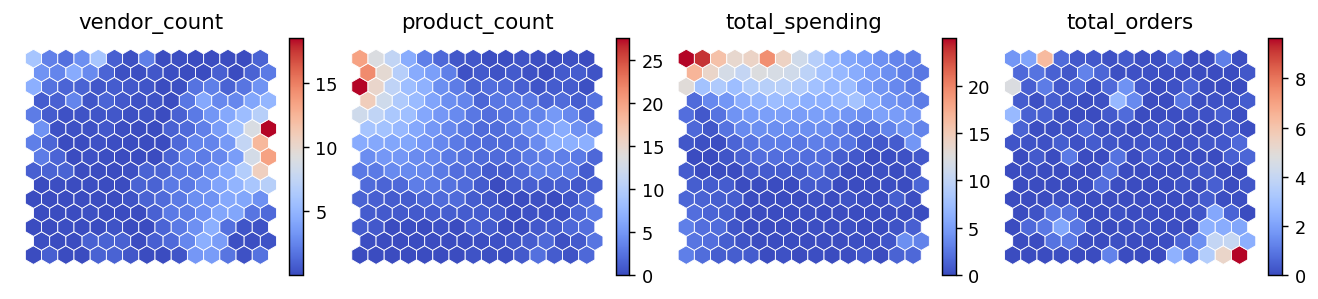

In [38]:
##############################
# Plot Component Planes
##############################

figsize=(10, 10)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(1,4,wspace=.08, hspace=.07)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(order_volume_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=order_volume_features[cpi],
                    cmap=cm.coolwarm,
                    )

Analysis of order volume SOM maps:

Vendor count: Scattered hotspots (max 15), primarily in right region, showing clusters of multi-vendor orders

Product count: High concentration (25) in top-left, indicating zones of large basket sizes

Total spending: Strong peaks (20+) in top, correlating with product count patterns

Total orders: More uniform distribution with isolated peak (8+), suggesting consistent order volumes with occasional high-traffic nodes

The maps reveal clear clustering of high-value, multi-item orders in specific regions, while general order volume remains relatively evenly distributed.